In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.spatial import distance
from IPython.display import display
from statsmodels.stats.anova import AnovaRM
import pingouin as pg
# data path for mat files, spreadsheet and other necessary csvs and output csv files are defined here
OG_DATA_PATH = "C:/Users/mein/Desktop/Cognitive Science/Saivr/Data/TaskResults/"
DATA_PATH = "C:/Users/mein/Desktop/Cognitive Science/Saivr/Data/"
PROCESSED_DATA_PATH = "C:/Users/mein/Desktop/Cognitive Science/Saivr/Data/Cohort2/csv_files/" #'./csv_files/'
#os.makedirs(os.path.dirname(PROCESSED_DATA_PATH), exist_ok=True)
sns.set(context = "poster", style="white", palette="dark", font_scale=2, rc={'figure.figsize':(12,9)})

When running this notebook for the first time, make sure that all to_csv commands that are needed are uncommented!

## Getting House angles and coordinates from csv

In [14]:
housedf = pd.read_csv(DATA_PATH+'seahaven_house_info.csv', sep=',')

# Finding valid subjects from control and exp. groups
* ### Subjects who have finished 4 sessions
* ### Subjects who have not been discarded because of faulty measurement

In [15]:
# import calender file, only load specified columns
df = pd.read_excel(DATA_PATH+'Seahaven_alignment_project.xlsx', usecols='A,C:G')
df["Training"] = df["Training"].str.lower()
df = df[df.Discarded != 'yes']
# only keep identifier (letter)
df["Repeated"]= df["Repeated"].str[1:]
df.rename(columns={"Subject#": "Subject", "Measurement#": "Measurement"}, inplace=True)
# I included 4j even though it is flagged as discarded (removed), because it was decided that we would allow more than 14 days between measurements in certain cases

In [16]:
Ctmpdf = (
    df
    .query('Measurement == 4')
    .query('Training == "belt_c"')
    [['Repeated']] 
)
Etmpdf = (
    df
    .query('Measurement == 4')
    .query('Training == "belt_e"')
    [['Repeated']] 
)
c_val_ids = Ctmpdf.Repeated.unique()
e_val_ids = Etmpdf.Repeated.unique()
display(c_val_ids)
display(e_val_ids)

array(['i', 'q', 'p', 'a', 'b', 'c', 'k'], dtype=object)

array(['g', 'b', 'j', 'f', 'k', 'i', 'h', 'a', 'd', 'sj', 'sa', 'sl',
       'so', 'si', 'sp', 'sd', 'se', 'sc', 'sb', 'sm', 'sh', 'sn', 'sq',
       'sg'], dtype=object)

In [17]:
c_measure = df[df.Training == "belt_c"][["Subject", "Measurement", "Repeated", "Training"]]
c_measure = c_measure[c_measure['Repeated'].isin(c_val_ids)]
c_val_subs = c_measure["Subject"].unique()
# get the data on all experimental participants
e_measure = df[df.Training == "belt_e"][["Subject", "Measurement", "Repeated", "Training"]]
e_measure = e_measure[e_measure['Repeated'].isin(e_val_ids)]
e_val_subs = e_measure["Subject"].unique()
# combine control and experimental subjects in one data frame
measure_df = pd.concat([c_measure, e_measure])
measure_df["Training"] = measure_df["Training"].str[-1]

print(np.sort(measure_df["Subject"].unique()))
print(len(measure_df["Subject"].unique()))

[1033 1208 1297 1316 1357 1449 1493 1535 1570 1753 1815 1844 1879 1906
 1921 1975 2015 2025 2121 2190 2288 2354 2366 2388 2497 2639 2647 2723
 2784 2855 2868 2869 2906 2989 3057 3142 3160 3288 3323 3597 3617 3750
 3868 4059 4134 4156 4160 4225 4270 4346 4471 4473 4493 4558 4570 4855
 4870 4935 4958 4991 5044 5149 5338 5348 5354 5356 5422 5532 5549 5617
 5631 5667 5701 5706 5732 5831 6061 6107 6224 6292 6378 6465 6520 6695
 6737 6832 6850 7023 7248 7450 7486 7568 7762 7807 7877 7972 7986 8039
 8089 8114 8207 8215 8253 8259 8663 8669 8670 8674 8740 8869 8902 8933
 8943 9008 9288 9332 9474 9580 9657 9662 9751 9842 9857 9942]
124


In [18]:
measure_df.drop(columns=["Training"], inplace=True)
measure_df.head()

,Subject,Measurement,Repeated
0,1208,3,b
3,1449,3,k
4,1815,2,p
6,1906,3,i
7,2121,1,i


# Reading Task performance data from .mat files

In [19]:
def mat_to_df(subNr,taskType):
    '''
    converts mat struct with task results into pandas df
    also adds extra column with information whether trial was correct or wrong    
    '''
    columns = {'Absolute': ['HouseNr', 'Correct_Angle', 'Wrong_Angle', 'Correct_Answer','RT',
               'Sub_Answer', 'Accurate', 'Time', 'Task', 'Subject'],
               
               'Relative': ['PrimeNr', 'TargetNr_correct', 'TargetNr_wrong', 'Correct_Answer','RT',
               'Sub_Answer', 'Accurate', 'Time', 'Task', 'Subject'],
               
               'Pointing': ['PrimeNr', 'TargetNr', 'Angle_correct', 'Angle_wrong','Correct_Answer','RT',
               'Sub_Answer', 'Accurate', 'Time', 'Task', 'Subject']
              }
    matpath = OG_DATA_PATH+"/AlignmentVR_SubjNo_"+ str(subNr) +".mat"
    if os.path.exists(matpath):
        mat_contents = spio.loadmat(matpath)
        type_array = []
        for j,cond_2 in enumerate(["Trial_3s", "Trial_Inf"]):
            trials_array = []
            for line in range(len(mat_contents['Output'][0][0][taskType][cond_2][0][0])):
                value_array = []
                for column in range(len(mat_contents['Output'][0][0][taskType][cond_2][0][0][line][0])):
                    value = mat_contents['Output'][0][0][taskType][cond_2][0][0][line][0][column][0][0]
                    value_array.append(value)
                # check if trial is correct(true or false
                value_array.append(value_array[-1] == value_array[-3])
                value_array.extend([cond_2.split('_')[1],taskType, subNr]) 
    #                 print(value_array)
                trials_array.append(value_array)
    #             print(len(value_array))
            type_array.extend(trials_array)
    #     print(type_array)
        return pd.DataFrame.from_records(type_array, columns=columns[taskType])
    else:
        print(matpath+' NOT FOUND!')
        return pd.DataFrame()

# Reading all Control data

In [20]:
abs_df = pd.concat([mat_to_df(sub, 'Absolute') for idx, sub in enumerate(c_val_subs)],
            ignore_index=True) 
#display(abs_df.head())
abs_df['AngularDiff'] = abs(abs_df.Correct_Angle - abs_df.Wrong_Angle)
abs_df.loc[abs_df['AngularDiff']>180, 'AngularDiff' ] = 360 - abs_df['AngularDiff']
abs_df['AngularDiff'] = abs_df['AngularDiff'].astype(str)
abs_df['Correct_Angle_180'] = abs_df.Correct_Angle
abs_df.loc[abs_df['Correct_Angle_180']>180, 'Correct_Angle_180' ] = 360 - abs_df['Correct_Angle_180']
# display(abs_df.Correct_Angle_180.value_counts(bins=7))
# bins = pd.IntervalIndex.from_tuples([(0, 10), (15, 45), (45, 75),(75,105),(105,135),(135,165),(165,195)])
# bins = [0,15,45,75,105,135,165,195]
abs_df['AngleToNorth'], bins = pd.cut(abs_df.Correct_Angle_180, bins=7,labels=[0,30,60,90,120,150,180], retbins=True)
abs_df['AngleToNorth'] = abs_df['AngleToNorth'].astype(str)
abs_df = abs_df.merge(measure_df, left_on="Subject", right_on="Subject")
display(abs_df.head())
display(abs_df.AngleToNorth.value_counts())

,HouseNr,Correct_Angle,Wrong_Angle,Correct_Answer,RT,Sub_Answer,Accurate,Time,Task,Subject,AngularDiff,Correct_Angle_180,AngleToNorth,Measurement,Repeated
0,194,150,330,D,1.166392,D,True,3s,Absolute,1208,180,150,150,3,b
1,136,120,90,U,1.302453,U,True,3s,Absolute,1208,30,120,120,3,b
2,140,303,243,D,1.483910,U,False,3s,Absolute,1208,60,57,60,3,b
3,55,90,210,D,0.959039,D,True,3s,Absolute,1208,120,90,90,3,b
4,56,0,180,U,1.648420,D,False,3s,Absolute,1208,180,0,0,3,b


150    364
90     336
60     336
30     308
120    308
180    196
0      168
Name: AngleToNorth, dtype: int64

In [21]:
rel_df = pd.concat([mat_to_df(sub, 'Relative') for idx, sub in enumerate(c_val_subs)],
            ignore_index=True) 
housedf.HouseNr = housedf.HouseNr.astype(int)

rel_df['Correct_Angle'] = rel_df.merge(housedf, left_on='TargetNr_correct', right_on='HouseNr', how='left')['Angle']
rel_df['Wrong_Angle'] = rel_df.merge(housedf, left_on='TargetNr_wrong', right_on='HouseNr', how='left')['Angle']
rel_df[['target_x', 'target_y']] = rel_df.merge(housedf, left_on='TargetNr_correct', right_on='HouseNr', how='left')[['x','y']]
rel_df[['prime_x', 'prime_y']] = rel_df.merge(housedf, left_on='PrimeNr', right_on='HouseNr', how='left')[['x','y']]
rel_df['distance_prime_target'] = np.sqrt((rel_df.prime_x - rel_df.target_x)**2 + (rel_df.prime_y - rel_df.target_y)**2 )
rel_df['AngularDiff'] = abs(rel_df.Correct_Angle - rel_df.Wrong_Angle)
rel_df.loc[rel_df['AngularDiff']>180, 'AngularDiff' ] = 360 - rel_df['AngularDiff']

# bins = pd.IntervalIndex.from_tuples([(0, 45), (45, 75),(75,105),(105,135),(135,165),(165,195)])
bins = [0,45,75,105,135,165,195]
rel_df['AngularDiff'] = pd.cut(rel_df.AngularDiff, bins=bins,labels=[30,60,90,120,150,180], retbins=False)

rel_df['AngularDiff'] = rel_df['AngularDiff'].astype(str)
rel_df = rel_df.merge(measure_df, left_on="Subject", right_on="Subject")

display(rel_df.AngularDiff.value_counts())
display(rel_df.head())

90     336
150    336
60     336
30     336
120    336
180    336
Name: AngularDiff, dtype: int64

,PrimeNr,TargetNr_correct,TargetNr_wrong,Correct_Answer,RT,Sub_Answer,Accurate,Time,Task,Subject,Correct_Angle,Wrong_Angle,target_x,target_y,prime_x,prime_y,distance_prime_target,AngularDiff,Measurement,Repeated
0,152,187,9,D,1.481494,D,True,3s,Relative,1208,240.0,180.0,432.4,631.7,525.3,717.4,126.391851,60,3,b
1,119,130,139,U,1.360504,D,False,3s,Relative,1208,210.0,300.0,540.9,855.2,412.0,779.9,149.282618,90,3,b
2,39,83,142,D,0.982155,D,True,3s,Relative,1208,180.0,210.0,659.8,841.0,647.9,876.3,37.251846,30,3,b
3,15,18,137,D,1.685775,D,True,3s,Relative,1208,0.0,120.0,399.5,717.9,397.9,749.6,31.740353,120,3,b
4,135,132,114,U,1.642597,U,True,3s,Relative,1208,120.0,305.0,573.6,881.9,439.3,657.3,261.689988,180,3,b


In [22]:
point_df = pd.concat([mat_to_df(sub, 'Pointing') for idx, sub in enumerate(c_val_subs)],
            ignore_index=True) 
point_df['AngularDiff'] = abs(point_df.Angle_correct - point_df.Angle_wrong)
point_df.loc[point_df['AngularDiff']>180, 'AngularDiff' ] = 360 - point_df['AngularDiff']
point_df['AngularDiff'] = point_df['AngularDiff'].astype(str)
point_df[['target_x', 'target_y']] = point_df.merge(housedf, left_on='TargetNr', right_on='HouseNr', how='left')[['x','y']]
point_df[['prime_x', 'prime_y']] = point_df.merge(housedf, left_on='PrimeNr', right_on='HouseNr', how='left')[['x','y']]
point_df['distance_prime_target'] = np.sqrt((point_df.prime_x - point_df.target_x)**2 + 
                                            (point_df.prime_y - point_df.target_y)**2 )
point_df = point_df.merge(measure_df, left_on="Subject", right_on="Subject")
display(point_df.head())

,PrimeNr,TargetNr,Angle_correct,Angle_wrong,Correct_Answer,RT,Sub_Answer,Accurate,Time,Task,Subject,AngularDiff,target_x,target_y,prime_x,prime_y,distance_prime_target,Measurement,Repeated
0,152,100,294,204,U,0.812907,U,True,3s,Pointing,1208,90,242.2,845.5,525.3,717.4,310.733358,3,b
1,133,110,140,290,D,0.986300,U,False,3s,Pointing,1208,150,480.1,813.0,597.1,827.9,117.944945,3,b
2,133,65,226,16,D,1.015057,D,True,3s,Pointing,1208,150,437.4,671.2,597.1,827.9,223.738642,3,b
3,113,47,205,265,D,1.029759,D,True,3s,Pointing,1208,60,198.7,826.2,494.3,704.6,319.634041,3,b
4,193,40,197,17,D,1.595389,U,False,3s,Pointing,1208,180,650.3,784.6,345.3,872.1,317.303089,3,b


In [23]:
# Make empty dataframe with task,SubjectID, PrimeNr, TargetNr , Accuracy
#save this house_task as csv
house_task_df = pd.DataFrame()

house_task_df = pd.concat([house_task_df, abs_df.loc[:,['Subject','Task','HouseNr',
                                                    'Time','Accurate','Measurement','Repeated']]], ignore_index=True)
house_task_df = pd.concat([house_task_df, rel_df.loc[:,['Subject','Task','PrimeNr','TargetNr_correct','TargetNr_wrong',
                                                'Time','Accurate','Measurement','Repeated']]], ignore_index=True)
house_task_df = pd.concat([house_task_df, point_df.loc[:,['Subject','Task','PrimeNr','TargetNr',
                                                'Time','Accurate','Measurement','Repeated']]], ignore_index=True)
house_task_df['Group'] = 'Control'
house_task_df = house_task_df.fillna('')
house_task_df[['HouseNr','PrimeNr','TargetNr','TargetNr_correct','TargetNr_wrong']] = house_task_df[['HouseNr',\
                                                 'PrimeNr','TargetNr','TargetNr_correct','TargetNr_wrong']].astype(str)


house_task_df['HouseNr'] = house_task_df['HouseNr'] + house_task_df['PrimeNr']
house_task_df['TargetNr'] = house_task_df['TargetNr'] + house_task_df['TargetNr_correct']
house_task_df.drop(columns=['PrimeNr','TargetNr_correct'], inplace=True)
house_task_df.rename(columns={'Accurate':'Accuracy','HouseNr':'PrimeNr'}, inplace=True)
display(house_task_df)
#house_task_df.to_csv(path_or_buf = PROCESSED_DATA_PATH+'control_house_task_accuracy.csv', index=False)

C:\Users\mein\Miniconda3\envs\acc\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
C:\Users\mein\Miniconda3\envs\acc\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


,Accuracy,PrimeNr,Measurement,Repeated,Subject,TargetNr,TargetNr_wrong,Task,Time,Group
0,True,194.0,3,b,1208,,,Absolute,3s,Control
1,True,136.0,3,b,1208,,,Absolute,3s,Control
2,False,140.0,3,b,1208,,,Absolute,3s,Control
3,True,55.0,3,b,1208,,,Absolute,3s,Control
4,False,56.0,3,b,1208,,,Absolute,3s,Control
...,...,...,...,...,...,...,...,...,...,...
6043,True,117.0,2,b,4059,102.0,,Pointing,Inf,Control
6044,False,33.0,2,b,4059,126.0,,Pointing,Inf,Control
6045,False,193.0,2,b,4059,11.0,,Pointing,Inf,Control
6046,True,180.0,2,b,4059,70.0,,Pointing,Inf,Control


In [24]:
north_alignment_c = (
    abs_df
    .groupby(['Subject','AngleToNorth','Time','Measurement','Repeated'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
)
north_alignment_c['Group'] = 'Control'
display(north_alignment_c)

df = pd.pivot_table(north_alignment_c, index=['Subject','Group','Measurement','Repeated'], values='Accuracy',columns=['AngleToNorth','Time'],
                    aggfunc='mean')
display(df.columns)
df.columns =['_'.join(col).rstrip('_') for col in df.columns.values]
display(df.columns)
#df.to_csv(path_or_buf = PROCESSED_DATA_PATH+'control_angletonorth_accuracy_time_wideform.csv', index=False)

,Subject,AngleToNorth,Time,Measurement,Repeated,Accuracy,Group
0,1208,0,3s,3,b,0.500000,Control
1,1208,0,Inf,3,b,0.500000,Control
2,1208,120,3s,3,b,0.500000,Control
3,1208,120,Inf,3,b,0.714286,Control
4,1208,150,3s,3,b,0.333333,Control
...,...,...,...,...,...,...,...
387,9857,30,Inf,4,k,0.600000,Control
388,9857,60,3s,4,k,0.142857,Control
389,9857,60,Inf,4,k,0.600000,Control
390,9857,90,3s,4,k,0.500000,Control


MultiIndex([(  '0',  '3s'),
            (  '0', 'Inf'),
            ('120',  '3s'),
            ('120', 'Inf'),
            ('150',  '3s'),
            ('150', 'Inf'),
            ('180',  '3s'),
            ('180', 'Inf'),
            ( '30',  '3s'),
            ( '30', 'Inf'),
            ( '60',  '3s'),
            ( '60', 'Inf'),
            ( '90',  '3s'),
            ( '90', 'Inf')],
           names=['AngleToNorth', 'Time'])

Index(['0_3s', '0_Inf', '120_3s', '120_Inf', '150_3s', '150_Inf', '180_3s',
       '180_Inf', '30_3s', '30_Inf', '60_3s', '60_Inf', '90_3s', '90_Inf'],
      dtype='object')

In [25]:
c_perf_df = pd.concat([
    (
    abs_df
    .groupby(['Subject','Task','Time','Measurement','Repeated'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    rel_df
    .groupby(['Subject','Task','Time','Measurement','Repeated'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    point_df
    .groupby(['Subject','Task','Time','Measurement','Repeated'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    )
]
)
c_perf_df['Group'] = 'Control'
display(c_perf_df.head())

,Subject,Task,Time,Measurement,Repeated,Accuracy,Group
0,1208,Absolute,3s,3,b,0.472222,Control
1,1208,Absolute,Inf,3,b,0.472222,Control
2,1449,Absolute,3s,3,k,0.527778,Control
3,1449,Absolute,Inf,3,k,0.500000,Control
4,1815,Absolute,3s,2,p,0.333333,Control


In [26]:
c_angdiff_df = pd.concat([
    (
    abs_df
    .groupby(['Subject','Task','Time','AngularDiff','Measurement','Repeated'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    rel_df
    .groupby(['Subject','Task','Time','AngularDiff','Measurement','Repeated'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    point_df
    .groupby(['Subject','Task','Time','AngularDiff','Measurement','Repeated'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    )
]
)
c_angdiff_df['Group'] = 'Control'
display(c_angdiff_df)

,Subject,Task,Time,AngularDiff,Measurement,Repeated,Accuracy,Group
0,1208,Absolute,3s,120,3,b,0.666667,Control
1,1208,Absolute,3s,150,3,b,0.666667,Control
2,1208,Absolute,3s,180,3,b,0.666667,Control
3,1208,Absolute,3s,30,3,b,0.500000,Control
4,1208,Absolute,3s,60,3,b,0.000000,Control
...,...,...,...,...,...,...,...,...
331,9857,Pointing,Inf,150,4,k,0.500000,Control
332,9857,Pointing,Inf,180,4,k,0.666667,Control
333,9857,Pointing,Inf,30,4,k,0.333333,Control
334,9857,Pointing,Inf,60,4,k,0.833333,Control


In [27]:
tmpdf = pd.concat([
    (
    rel_df
    .groupby(['Task','Time','PrimeNr','TargetNr_correct', 'distance_prime_target','Measurement'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    point_df
    .groupby(['Task','Time','PrimeNr','TargetNr','distance_prime_target','Measurement'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    )
    
])
tmpdf['Group'] = 'Control'
#tmpdf.to_csv(path_or_buf = PROCESSED_DATA_PATH+'control_rel_point_distance_accuracy.csv', index=False)

display(tmpdf)

C:\Users\mein\Miniconda3\envs\acc\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


,Accuracy,Measurement,PrimeNr,TargetNr,TargetNr_correct,Task,Time,distance_prime_target,Group
0,0.000000,1,15,NaN,18.0,Relative,3s,31.740353,Control
1,1.000000,2,15,NaN,18.0,Relative,3s,31.740353,Control
2,0.428571,3,15,NaN,18.0,Relative,3s,31.740353,Control
3,0.428571,4,15,NaN,18.0,Relative,3s,31.740353,Control
4,0.714286,1,15,NaN,36.0,Relative,3s,158.913089,Control
...,...,...,...,...,...,...,...,...,...
283,0.571429,4,193,11.0,NaN,Pointing,Inf,161.044621,Control
284,0.285714,1,193,77.0,NaN,Pointing,Inf,167.993155,Control
285,0.571429,2,193,77.0,NaN,Pointing,Inf,167.993155,Control
286,0.571429,3,193,77.0,NaN,Pointing,Inf,167.993155,Control


# Reading all Experimental data

In [28]:
abs_df = pd.concat([mat_to_df(sub, 'Absolute') for idx, sub in enumerate(e_val_subs)],
            ignore_index=True) 
abs_df['AngularDiff'] = abs(abs_df.Correct_Angle - abs_df.Wrong_Angle)
abs_df.loc[abs_df['AngularDiff']>180, 'AngularDiff' ] = 360 - abs_df['AngularDiff']
abs_df['AngularDiff'] = abs_df['AngularDiff'].astype(str)
abs_df['Correct_Angle_180'] = abs_df.Correct_Angle
abs_df.loc[abs_df['Correct_Angle_180']>180, 'Correct_Angle_180' ] = 360 - abs_df['Correct_Angle_180']
# display(abs_df.Correct_Angle_180.value_counts(bins=7))
# bins = pd.IntervalIndex.from_tuples([(0, 10), (15, 45), (45, 75),(75,105),(105,135),(135,165),(165,195)])
#bins = [0,15,45,75,105,135,165,195]
abs_df['AngleToNorth'], bins = pd.cut(abs_df.Correct_Angle_180, bins=7,labels=[0,30,60,90,120,150,180], retbins=True)
abs_df['AngleToNorth'] = abs_df['AngleToNorth'].astype(str)
abs_df = abs_df.merge(measure_df, left_on="Subject", right_on="Subject")
display(abs_df.AngleToNorth.value_counts())

150    1248
90     1152
60     1152
120    1056
30     1056
180     672
0       576
Name: AngleToNorth, dtype: int64

In [29]:
rel_df = pd.concat([mat_to_df(sub, 'Relative') for idx, sub in enumerate(e_val_subs)],
            ignore_index=True) 

rel_df['Correct_Angle'] = rel_df.merge(housedf, left_on='TargetNr_correct', right_on='HouseNr', how='left')['Angle']
rel_df['Wrong_Angle'] = rel_df.merge(housedf, left_on='TargetNr_wrong', right_on='HouseNr', how='left')['Angle']
rel_df[['target_x', 'target_y']] = rel_df.merge(housedf, left_on='TargetNr_correct', right_on='HouseNr', how='left')[['x','y']]
rel_df[['prime_x', 'prime_y']] = rel_df.merge(housedf, left_on='PrimeNr', right_on='HouseNr', how='left')[['x','y']]
rel_df['distance_prime_target'] = np.sqrt((rel_df.prime_x - rel_df.target_x)**2 + (rel_df.prime_y - rel_df.target_y)**2 )
rel_df['AngularDiff'] = abs(rel_df.Correct_Angle - rel_df.Wrong_Angle)
rel_df.loc[rel_df['AngularDiff']>180, 'AngularDiff' ] = 360 - rel_df['AngularDiff']

# bins = pd.IntervalIndex.from_tuples([(0, 45), (45, 75),(75,105),(105,135),(135,165),(165,195)])
bins = [0,45,75,105,135,165,195]
rel_df['AngularDiff'] = pd.cut(rel_df.AngularDiff, bins=bins,labels=[30,60,90,120,150,180], retbins=False)

rel_df['AngularDiff'] = rel_df['AngularDiff'].astype(str)
rel_df = rel_df.merge(measure_df, left_on="Subject", right_on="Subject")
display(rel_df.AngularDiff.value_counts())
display(rel_df.head())

90     1152
120    1152
30     1152
150    1152
60     1152
180    1152
Name: AngularDiff, dtype: int64

,PrimeNr,TargetNr_correct,TargetNr_wrong,Correct_Answer,RT,Sub_Answer,Accurate,Time,Task,Subject,Correct_Angle,Wrong_Angle,target_x,target_y,prime_x,prime_y,distance_prime_target,AngularDiff,Measurement,Repeated
0,81,52,148,D,1.811417,D,True,3s,Relative,1493,90.0,60.0,435.2,769.9,439.8,950.2,180.358670,30,4,g
1,39,83,142,U,1.387746,U,True,3s,Relative,1493,180.0,210.0,659.8,841.0,647.9,876.3,37.251846,30,4,g
2,113,104,199,D,1.363864,D,True,3s,Relative,1493,210.0,60.0,419.5,764.4,494.3,704.6,95.765756,150,4,g
3,76,99,102,U,1.589151,U,True,3s,Relative,1493,270.0,30.0,260.4,845.0,380.3,794.5,130.100961,120,4,g
4,117,110,53,D,2.862987,D,True,3s,Relative,1493,30.0,90.0,480.1,813.0,394.9,790.9,88.019600,60,4,g


In [30]:
point_df = pd.concat([mat_to_df(sub, 'Pointing') for idx, sub in enumerate(e_val_subs)],
            ignore_index=True) 
point_df['AngularDiff'] = abs(point_df.Angle_correct - point_df.Angle_wrong)
point_df.loc[point_df['AngularDiff']>180, 'AngularDiff' ] = 360 - point_df['AngularDiff']
point_df['AngularDiff'] = point_df['AngularDiff'].astype(str)
point_df[['target_x', 'target_y']] = point_df.merge(housedf, left_on='TargetNr', right_on='HouseNr', how='left')[['x','y']]
point_df[['prime_x', 'prime_y']] = point_df.merge(housedf, left_on='PrimeNr', right_on='HouseNr', how='left')[['x','y']]
point_df['distance_prime_target'] = np.sqrt((point_df.prime_x - point_df.target_x)**2 + 
                                            (point_df.prime_y - point_df.target_y)**2 )
point_df = point_df.merge(measure_df, left_on="Subject", right_on="Subject")
display(point_df.head())

,PrimeNr,TargetNr,Angle_correct,Angle_wrong,Correct_Answer,RT,Sub_Answer,Accurate,Time,Task,Subject,AngularDiff,target_x,target_y,prime_x,prime_y,distance_prime_target,Measurement,Repeated
0,33,177,287,317,D,1.277009,D,True,3s,Pointing,1493,30,523.5,692.9,495.2,885.6,194.766989,4,g
1,39,107,190,220,D,1.567691,U,False,3s,Pointing,1493,30,509.6,717.6,647.9,876.3,210.505534,4,g
2,55,58,128,248,U,1.143164,D,False,3s,Pointing,1493,120,540.5,723.5,437.6,803.8,130.523944,4,g
3,131,114,210,0,D,1.305012,D,True,3s,Pointing,1493,150,395.8,770.1,537.3,843.6,159.450619,4,g
4,33,9,243,213,U,2.187551,U,True,3s,Pointing,1493,30,541.8,795.2,495.2,885.6,101.704081,4,g


In [31]:
# Make empty dataframe with task,SubjectID, PrimeNr, TargetNr , Accuracy
#save this house_task as csv
house_task_df = pd.DataFrame()

house_task_df = pd.concat([house_task_df, abs_df.loc[:,['Subject','Task','HouseNr',
                                                    'Time','Accurate','Measurement','Repeated']]], ignore_index=True)
house_task_df = pd.concat([house_task_df, rel_df.loc[:,['Subject','Task','PrimeNr','TargetNr_correct','TargetNr_wrong',
                                                'Time','Accurate','Measurement','Repeated']]], ignore_index=True)
house_task_df = pd.concat([house_task_df, point_df.loc[:,['Subject','Task','PrimeNr','TargetNr',
                                                'Time','Accurate','Measurement','Repeated']]], ignore_index=True)
house_task_df['Group'] = 'Exp'
house_task_df = house_task_df.fillna('')
house_task_df[['HouseNr','PrimeNr','TargetNr','TargetNr_correct','TargetNr_wrong']] = house_task_df[['HouseNr',\
                                                 'PrimeNr','TargetNr','TargetNr_correct','TargetNr_wrong']].astype(str)


house_task_df['HouseNr'] = house_task_df['HouseNr'] + house_task_df['PrimeNr']
house_task_df['TargetNr'] = house_task_df['TargetNr'] + house_task_df['TargetNr_correct']
house_task_df.drop(columns=['PrimeNr','TargetNr_correct'], inplace=True)
house_task_df.rename(columns={'Accurate':'Accuracy','HouseNr':'PrimeNr'}, inplace=True)
display(house_task_df)
#house_task_df.to_csv(path_or_buf = PROCESSED_DATA_PATH+'exp_house_task_accuracy.csv', index=False)

C:\Users\mein\Miniconda3\envs\acc\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
C:\Users\mein\Miniconda3\envs\acc\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


,Accuracy,PrimeNr,Measurement,Repeated,Subject,TargetNr,TargetNr_wrong,Task,Time,Group
0,True,56.0,4,g,1493,,,Absolute,3s,Exp
1,True,145.0,4,g,1493,,,Absolute,3s,Exp
2,True,91.0,4,g,1493,,,Absolute,3s,Exp
3,True,53.0,4,g,1493,,,Absolute,3s,Exp
4,False,176.0,4,g,1493,,,Absolute,3s,Exp
...,...,...,...,...,...,...,...,...,...,...
20731,True,135.0,4,sg,2855,187.0,,Pointing,Inf,Exp
20732,False,39.0,4,sg,2855,71.0,,Pointing,Inf,Exp
20733,False,133.0,4,sg,2855,69.0,,Pointing,Inf,Exp
20734,False,152.0,4,sg,2855,53.0,,Pointing,Inf,Exp


In [32]:
north_alignment_e = (
    abs_df
    .groupby(['Subject','AngleToNorth','Time','Measurement','Repeated'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
)
north_alignment_e['Group'] = 'Exp'
display(north_alignment_e)
df = pd.pivot_table(north_alignment_e, index=['Subject','Group','Measurement','Repeated'], values='Accuracy',columns=['AngleToNorth','Time'],
                    aggfunc='mean').reset_index()
display(df.head())
df.columns =['_'.join(col).rstrip('_') for col in df.columns.values]
display(df.columns)
#df.to_csv(path_or_buf = PROCESSED_DATA_PATH+'exp_angletonorth_accuracy_time_wideform.csv', index=False)

,Subject,AngleToNorth,Time,Measurement,Repeated,Accuracy,Group
0,1033,0,3s,1,sg,0.750000,Exp
1,1033,0,Inf,1,sg,0.500000,Exp
2,1033,120,3s,1,sg,0.250000,Exp
3,1033,120,Inf,1,sg,0.285714,Exp
4,1033,150,3s,1,sg,0.500000,Exp
...,...,...,...,...,...,...,...
1339,9942,30,Inf,2,sj,0.600000,Exp
1340,9942,60,3s,2,sj,0.142857,Exp
1341,9942,60,Inf,2,sj,0.600000,Exp
1342,9942,90,3s,2,sj,0.666667,Exp


AngleToNorth Subject Group Measurement Repeated     0        120            \
Time                                               3s  Inf    3s       Inf   
0               1033   Exp           1       sg  0.75  0.5  0.25  0.285714   
1               1297   Exp           3       sd  0.75  0.5  0.50  0.571429   
2               1316   Exp           3       sh  0.50  0.5  0.25  0.857143   
3               1357   Exp           1       se  0.75  1.0  0.50  0.285714   
4               1493   Exp           4        g  0.50  1.0  0.25  0.714286   

AngleToNorth       150                 180              30             60  \
Time                3s       Inf        3s   Inf        3s  Inf        3s   
0             0.500000  0.428571  0.666667  0.25  0.500000  0.4  0.714286   
1             0.333333  0.857143  0.666667  0.75  0.833333  0.6  0.571429   
2             0.333333  0.571429  0.666667  0.50  0.500000  0.8  0.428571   
3             0.500000  0.571429  0.666667  1.00  0.833333  0.2  0.571429   
4             0.833333  0.857143  1.000000  0.75  0.666667  0.6  0.428571   

AngleToNorth             90            
Time          Inf        3s       Inf  
0             0.6  1.000000  0.833333  
1             1.0  0.333333  0.500000  
2             1.0  0.833333  0.833333  
3             0.6  1.000000  0.666667  
4             0.6  0.833333  0.333333

Index(['Subject', 'Group', 'Measurement', 'Repeated', '0_3s', '0_Inf',
       '120_3s', '120_Inf', '150_3s', '150_Inf', '180_3s', '180_Inf', '30_3s',
       '30_Inf', '60_3s', '60_Inf', '90_3s', '90_Inf'],
      dtype='object')

In [33]:
e_perf_df = pd.concat([
    (
    abs_df
    .groupby(['Subject','Task','Time','Measurement','Repeated'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    rel_df
    .groupby(['Subject','Task','Time','Measurement','Repeated'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    point_df
    .groupby(['Subject','Task','Time','Measurement','Repeated'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    )
]
)
e_perf_df['Group'] = 'Exp'
display(e_perf_df)

,Subject,Task,Time,Measurement,Repeated,Accuracy,Group
0,1033,Absolute,3s,1,sg,0.638889,Exp
1,1033,Absolute,Inf,1,sg,0.472222,Exp
2,1297,Absolute,3s,3,sd,0.555556,Exp
3,1297,Absolute,Inf,3,sd,0.694444,Exp
4,1316,Absolute,3s,3,sh,0.500000,Exp
...,...,...,...,...,...,...,...
187,9662,Pointing,Inf,2,se,0.416667,Exp
188,9842,Pointing,3s,4,sp,0.583333,Exp
189,9842,Pointing,Inf,4,sp,0.361111,Exp
190,9942,Pointing,3s,2,sj,0.555556,Exp


In [34]:
all_data = pd.concat([c_perf_df,e_perf_df])
display(all_data.isna().sum())
#all_data.to_csv(path_or_buf = PROCESSED_DATA_PATH+'task_time_accuracy.csv', index=False)

# pd.melt(all_data,id_vars=['Subject','Group'],value_vars=[])
df = pd.pivot_table(all_data, index=['Subject','Group','Measurement','Repeated'], values='Accuracy',columns=['Task','Time']).reset_index()
display(df.isna().sum())
df.columns =['_'.join(col).rstrip('_') for col in df.columns.values]
display(df.isna().sum())
#df.to_csv(path_or_buf = PROCESSED_DATA_PATH+'task_time_accuracy_wideform.csv', index=False)

Subject        0
Task           0
Time           0
Measurement    0
Repeated       0
Accuracy       0
Group          0
dtype: int64

Task         Time
Subject              0
Group                0
Measurement          0
Repeated             0
Absolute     3s      0
             Inf     0
Pointing     3s      0
             Inf     0
Relative     3s      0
             Inf     0
dtype: int64

Subject         0
Group           0
Measurement     0
Repeated        0
Absolute_3s     0
Absolute_Inf    0
Pointing_3s     0
Pointing_Inf    0
Relative_3s     0
Relative_Inf    0
dtype: int64

In [35]:
e_angdiff_df = pd.concat([
    (
    abs_df
    .groupby(['Subject','Task','Time','AngularDiff','Measurement','Repeated'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    rel_df
    .groupby(['Subject','Task','Time','AngularDiff','Measurement','Repeated'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    point_df
    .groupby(['Subject','Task','Time','AngularDiff','Measurement','Repeated'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    )
]
)
e_angdiff_df['Group'] = 'Exp'
display(e_angdiff_df)

,Subject,Task,Time,AngularDiff,Measurement,Repeated,Accuracy,Group
0,1033,Absolute,3s,120,1,sg,0.833333,Exp
1,1033,Absolute,3s,150,1,sg,0.500000,Exp
2,1033,Absolute,3s,180,1,sg,0.500000,Exp
3,1033,Absolute,3s,30,1,sg,0.833333,Exp
4,1033,Absolute,3s,60,1,sg,0.666667,Exp
...,...,...,...,...,...,...,...,...
1147,9942,Pointing,Inf,150,2,sj,0.833333,Exp
1148,9942,Pointing,Inf,180,2,sj,0.666667,Exp
1149,9942,Pointing,Inf,30,2,sj,0.333333,Exp
1150,9942,Pointing,Inf,60,2,sj,0.500000,Exp


In [36]:
tmpdf = pd.concat([
    (
    rel_df
    .groupby(['Task','Time','PrimeNr','TargetNr_correct', 'distance_prime_target','Measurement'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    point_df
    .groupby(['Task','Time','PrimeNr','TargetNr','distance_prime_target','Measurement'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    )
    
])
tmpdf['Group'] = 'Exp'
#tmpdf.to_csv(path_or_buf = PROCESSED_DATA_PATH+'exp_rel_point_distance_accuracy.csv', index=False)

display(tmpdf)

C:\Users\mein\Miniconda3\envs\acc\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


,Accuracy,Measurement,PrimeNr,TargetNr,TargetNr_correct,Task,Time,distance_prime_target,Group
0,0.583333,1,15,NaN,18.0,Relative,3s,31.740353,Exp
1,0.208333,2,15,NaN,18.0,Relative,3s,31.740353,Exp
2,0.416667,3,15,NaN,18.0,Relative,3s,31.740353,Exp
3,0.500000,4,15,NaN,18.0,Relative,3s,31.740353,Exp
4,0.458333,1,15,NaN,36.0,Relative,3s,158.913089,Exp
...,...,...,...,...,...,...,...,...,...
283,0.291667,4,193,11.0,NaN,Pointing,Inf,161.044621,Exp
284,0.541667,1,193,77.0,NaN,Pointing,Inf,167.993155,Exp
285,0.458333,2,193,77.0,NaN,Pointing,Inf,167.993155,Exp
286,0.625000,3,193,77.0,NaN,Pointing,Inf,167.993155,Exp


In [37]:
all_angdiff_data = pd.concat([c_angdiff_df,e_angdiff_df])
display(all_angdiff_data)
#all_angdiff_data.to_csv(path_or_buf = PROCESSED_DATA_PATH+'angulardifference_time_accuracy.csv', index=False)
df = pd.pivot_table(all_angdiff_data, index=['Subject','Group','Measurement','Repeated'], values='Accuracy',columns=['AngularDiff','Time'],
                    aggfunc='mean').reset_index()
display(df.columns)
df.columns =['_'.join(col).rstrip('_') for col in df.columns.values]
display(df.columns)
#df.to_csv(path_or_buf = PROCESSED_DATA_PATH+'angulardifference_time_accuracy_wideform.csv', index=False)

,Subject,Task,Time,AngularDiff,Measurement,Repeated,Accuracy,Group
0,1208,Absolute,3s,120,3,b,0.666667,Control
1,1208,Absolute,3s,150,3,b,0.666667,Control
2,1208,Absolute,3s,180,3,b,0.666667,Control
3,1208,Absolute,3s,30,3,b,0.500000,Control
4,1208,Absolute,3s,60,3,b,0.000000,Control
...,...,...,...,...,...,...,...,...
1147,9942,Pointing,Inf,150,2,sj,0.833333,Exp
1148,9942,Pointing,Inf,180,2,sj,0.666667,Exp
1149,9942,Pointing,Inf,30,2,sj,0.333333,Exp
1150,9942,Pointing,Inf,60,2,sj,0.500000,Exp


MultiIndex([(    'Subject',    ''),
            (      'Group',    ''),
            ('Measurement',    ''),
            (   'Repeated',    ''),
            (        '120',  '3s'),
            (        '120', 'Inf'),
            (        '150',  '3s'),
            (        '150', 'Inf'),
            (        '180',  '3s'),
            (        '180', 'Inf'),
            (         '30',  '3s'),
            (         '30', 'Inf'),
            (         '60',  '3s'),
            (         '60', 'Inf'),
            (         '90',  '3s'),
            (         '90', 'Inf')],
           names=['AngularDiff', 'Time'])

Index(['Subject', 'Group', 'Measurement', 'Repeated', '120_3s', '120_Inf',
       '150_3s', '150_Inf', '180_3s', '180_Inf', '30_3s', '30_Inf', '60_3s',
       '60_Inf', '90_3s', '90_Inf'],
      dtype='object')

In [38]:
north_alignment = pd.concat([north_alignment_c,north_alignment_e])
display(north_alignment)
#north_alignment.to_csv(path_or_buf = PROCESSED_DATA_PATH+'angletonorth_time_accuracy.csv', index=False)

df = pd.pivot_table(north_alignment, index=['Group','Subject','Measurement','Repeated'], values='Accuracy',columns=['AngleToNorth','Time'],
                    aggfunc='mean').reset_index()
display(df.columns)
df.columns =['_'.join(col).rstrip('_') for col in df.columns.values]
display(df.columns)
#df.to_csv(path_or_buf = PROCESSED_DATA_PATH+'angletonorth_time_accuracy_wideform.csv', index=False)

,Subject,AngleToNorth,Time,Measurement,Repeated,Accuracy,Group
0,1208,0,3s,3,b,0.500000,Control
1,1208,0,Inf,3,b,0.500000,Control
2,1208,120,3s,3,b,0.500000,Control
3,1208,120,Inf,3,b,0.714286,Control
4,1208,150,3s,3,b,0.333333,Control
...,...,...,...,...,...,...,...
1339,9942,30,Inf,2,sj,0.600000,Exp
1340,9942,60,3s,2,sj,0.142857,Exp
1341,9942,60,Inf,2,sj,0.600000,Exp
1342,9942,90,3s,2,sj,0.666667,Exp


MultiIndex([(      'Group',    ''),
            (    'Subject',    ''),
            ('Measurement',    ''),
            (   'Repeated',    ''),
            (          '0',  '3s'),
            (          '0', 'Inf'),
            (        '120',  '3s'),
            (        '120', 'Inf'),
            (        '150',  '3s'),
            (        '150', 'Inf'),
            (        '180',  '3s'),
            (        '180', 'Inf'),
            (         '30',  '3s'),
            (         '30', 'Inf'),
            (         '60',  '3s'),
            (         '60', 'Inf'),
            (         '90',  '3s'),
            (         '90', 'Inf')],
           names=['AngleToNorth', 'Time'])

Index(['Group', 'Subject', 'Measurement', 'Repeated', '0_3s', '0_Inf',
       '120_3s', '120_Inf', '150_3s', '150_Inf', '180_3s', '180_Inf', '30_3s',
       '30_Inf', '60_3s', '60_Inf', '90_3s', '90_Inf'],
      dtype='object')

In [39]:
rel_df.columns

Index(['PrimeNr', 'TargetNr_correct', 'TargetNr_wrong', 'Correct_Answer', 'RT',
       'Sub_Answer', 'Accurate', 'Time', 'Task', 'Subject', 'Correct_Angle',
       'Wrong_Angle', 'target_x', 'target_y', 'prime_x', 'prime_y',
       'distance_prime_target', 'AngularDiff', 'Measurement', 'Repeated'],
      dtype='object')

# Combine task performance and FRS data

### Get subject indices and merge with FRS scales to join task accuracy and FRS score in one df
So far this is only implemented for C1 as I am missing some FRS data for C2

In [32]:
# combine FRS score of first FRS questionnaire with performance data of last measurement?! 
# Does this make sense?! 
FRS_scales = pd.read_csv(DATA_PATH + 'Cohort1.csv', sep=',', na_values=' ') 
display(FRS_scales.info())
FRS_scales.columns = ['VP1','VP2','VP3','VP4','Gender','Group','Age','Egocentric','Allocentric','Cardinal Direction']
FRS_scales.VP4 = FRS_scales.VP4.astype(str)
FRS_scales_long = pd.melt(FRS_scales, id_vars=['VP4'], value_vars=['Egocentric','Allocentric','Cardinal Direction'],
                     var_name='Scale',value_name='Score')

# get only performance in last measurement for both groups
perf_df = all_data[all_data['Measurement']==4]
perf_df.Subject = perf_df.Subject.astype(str)
# merge with FRS df
FRS_long = perf_df.merge(FRS_scales_long,left_on='Subject', right_on='VP4')
display(FRS_long)
FRS_long.drop(columns=['VP4','Measurement','Repeated'], inplace=True)
FRS_long.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_task4_time_FRS1_long.csv', index=False)

pivot_perf = pd.pivot_table(perf_df, 
                   index=['Subject','Group'], 
                   values='Accuracy',
                   columns=['Task','Time'],
                   aggfunc='mean').reset_index()
pivot_perf.Subject = pivot_perf.Subject.astype(str)
pivot_perf.columns = ['_'.join(col).rstrip('_') for col in pivot_perf.columns.values]
FRS_scales.drop(columns=['Group'])
tmpdf = pivot_perf.merge(FRS_scales, left_on='Subject', right_on='VP4')
tmpdf.drop(columns=['VP4'], inplace=True)
tmpdf.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_task4_time_FRS1_wideform.csv', index=False)
# display(tmpdf)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
VP1             16 non-null int64
 VP2            16 non-null int64
 VP3            16 non-null int64
 VP4            16 non-null int64
 Gender         16 non-null object
 Group          16 non-null object
 Age            16 non-null int64
 Scale1final    16 non-null float64
 Scale2final    16 non-null float64
 Scale3final    16 non-null float64
dtypes: float64(3), int64(5), object(2)
memory usage: 1.4+ KB


None

,Group,Repeated,Subject,Task,Time,Measurement,Accuracy,VP1,Scale,Score
0,Control,i,2121,Absolute,3s,1,0.444444,2121,Egocentric,5.00
1,Control,i,2121,Absolute,3s,1,0.444444,2121,Allocentric,4.57
2,Control,i,2121,Absolute,3s,1,0.444444,2121,Cardinal Direction,3.00
3,Control,i,2121,Absolute,Inf,1,0.472222,2121,Egocentric,5.00
4,Control,i,2121,Absolute,Inf,1,0.472222,2121,Allocentric,4.57
...,...,...,...,...,...,...,...,...,...,...
283,Exp,k,8670,Pointing,3s,1,0.416667,8670,Allocentric,2.29
284,Exp,k,8670,Pointing,3s,1,0.416667,8670,Cardinal Direction,2.50
285,Exp,k,8670,Pointing,Inf,1,0.555556,8670,Egocentric,2.10
286,Exp,k,8670,Pointing,Inf,1,0.555556,8670,Allocentric,2.29


## SCRATCH PAD

,Group,Task,Time,Repeated,Accuracy [%]
0,Control,Absolute,3s,a,0.479167
1,Control,Absolute,3s,b,0.500000
2,Control,Absolute,3s,c,0.493056
3,Control,Absolute,3s,i,0.479167
4,Control,Absolute,3s,k,0.562500
...,...,...,...,...,...
181,Exp,Relative,Inf,sm,0.451389
182,Exp,Relative,Inf,sn,0.527778
183,Exp,Relative,Inf,so,0.506944
184,Exp,Relative,Inf,sp,0.493056


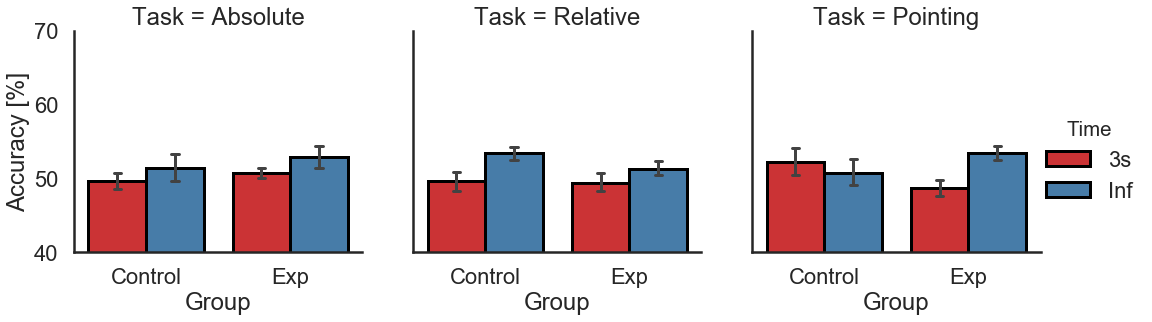

In [40]:
tmpdf = (
    all_data
    .groupby(['Group','Task','Time','Repeated'])
    .agg({'Accuracy':'mean'})
    .rename(columns={'Accuracy':'Accuracy [%]'})
    .reset_index()
#     .query('Time == "Inf"')
)

display(tmpdf)
sns.set(context = "poster", style="white", palette="Set1", font_scale=1, rc={'figure.figsize':(16,12), "font.family": "sans serif" })
tmpdf['Accuracy [%]'] = tmpdf['Accuracy [%]']*100
# tmpdf['AngularDiff'] = tmpdf['AngularDiff'].astype(int)
# _, ax = plt.subplots(figsize=(16,12))
ax = sns.catplot(data=tmpdf, x='Group', y='Accuracy [%]',hue='Time',col='Task', kind='bar', ci=68,
            capsize=0.05, col_order=['Absolute','Relative','Pointing'],
            edgecolor=(0,0,0),errwidth=3,linewidth=3,
           )
# sns.despine(ax=ax, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
# ax.axhline(50, ls=':', color='k', lw=4)
# ax.set_ylabel('Accuracy [%]')
# ax.set_xlabel('Alignment To North [$^\circ$]')
ax.set(ylim=(40,70));
# ax.legend(title='', loc='upper right', fontsize=25)
#plt.savefig(PLOTS_PATH+'/group_task_time_accuracy.png', quality=90)

Check impact of angular difference on performance for relative and pointing tasks

In [41]:
tmpdf = all_angdiff_data.query('Time == "Inf" ')
angdiff_anova_group = pg.mixed_anova(dv='Accuracy',within='AngularDiff',subject='Subject', between='Group', data=tmpdf) 
pg.print_table(angdiff_anova_group)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2  eps
-----------  -----  -----  -----  -----  -----  -------  -----  -----
Group        0.007      1    122  0.007  0.322    0.572  0.003  -
AngularDiff  0.505      5    610  0.101  7.631    0.000  0.059  0.956
Interaction  0.143      5    610  0.029  2.159    0.057  0.017  -



In [42]:
tmpdf.head()

,Subject,Task,Time,AngularDiff,Measurement,Repeated,Accuracy,Group
6,1208,Absolute,Inf,120,3,b,0.500000,Control
7,1208,Absolute,Inf,150,3,b,0.500000,Control
8,1208,Absolute,Inf,180,3,b,0.333333,Control
9,1208,Absolute,Inf,30,3,b,0.666667,Control
10,1208,Absolute,Inf,60,3,b,0.333333,Control


In [43]:
e_angdiff_res = AnovaRM(e_angdiff_df,'Accuracy','Subject', within=['AngularDiff','Time'], aggregate_func='mean').fit()
print(e_angdiff_res.summary())

                     Anova
                 F Value Num DF  Den DF  Pr > F
-----------------------------------------------
AngularDiff       3.0290 5.0000 475.0000 0.0106
Time             19.8473 1.0000  95.0000 0.0000
AngularDiff:Time  8.6652 5.0000 475.0000 0.0000



In [44]:
c_angdiff_res = AnovaRM(c_angdiff_df,'Accuracy','Subject', within=['AngularDiff','Time'], aggregate_func='mean').fit()
print(c_angdiff_res.summary())

                     Anova
                 F Value Num DF  Den DF  Pr > F
-----------------------------------------------
AngularDiff       3.0583 5.0000 135.0000 0.0120
Time              1.4435 1.0000  27.0000 0.2400
AngularDiff:Time  1.6791 5.0000 135.0000 0.1438



In [45]:
post_hoc = pg.pairwise_ttests(dv='Accuracy', within='Time', between='Group', subject='Subject',
                   data=all_data, padjust='bonf')
pg.print_table(post_hoc)


POST HOC TESTS

Contrast      Time    A        B    Paired    Parametric         T      dof  Tail         p-unc    p-corr  p-adjust       BF10    hedges
------------  ------  -------  ---  --------  ------------  ------  -------  ---------  -------  --------  ----------  -------  --------
Time          -       3s       Inf  True      True          -4.190  371.000  two-sided    0.000   nan      nan         288.925    -0.291
Group         -       Control  Exp  False     True           0.129  299.410  two-sided    0.898   nan      nan           0.098     0.011
Time * Group  3s      Control  Exp  False     True           0.868  136.620  two-sided    0.387     0.774  bonf          0.194     0.107
Time * Group  Inf     Control  Exp  False     True          -0.696  159.110  two-sided    0.488     0.976  bonf          0.171    -0.078



In [46]:
post_hoc = pg.pairwise_ttests(dv='Accuracy', within='Task', between='Group', subject='Subject',
                   data=all_data, padjust='fdr_bh')
pg.print_table(post_hoc)


POST HOC TESTS

Contrast      Task      A         B         Paired    Parametric         T      dof  Tail         p-unc    p-corr  p-adjust      BF10    hedges
------------  --------  --------  --------  --------  ------------  ------  -------  ---------  -------  --------  ----------  ------  --------
Task          -         Absolute  Relative  True      True           1.268  247.000  two-sided    0.206     0.618  fdr_bh       0.157     0.103
Task          -         Absolute  Pointing  True      True           0.476  247.000  two-sided    0.634     0.634  fdr_bh       0.080     0.041
Task          -         Relative  Pointing  True      True          -0.797  247.000  two-sided    0.426     0.634  fdr_bh       0.097    -0.067
Group         -         Control   Exp       False     True           0.129  299.410  two-sided    0.898   nan      nan          0.098     0.011
Task * Group  Absolute  Control   Exp       False     True          -0.904   90.030  two-sided    0.368     0.552  fdr_

In [47]:
anova_group = pg.mixed_anova(dv='Accuracy',within='Task',subject='Subject', between='Group', data=all_data) 
pg.print_table(anova_group)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2  eps
-----------  -----  -----  -----  -----  -----  -------  -----  -----
Group        0.000      1    122  0.000  0.000    1.000  0.000  -
Task         0.006      2    244  0.003  0.933    0.395  0.008  0.997
Interaction  0.007      2    244  0.003  1.039    0.355  0.008  -



In [48]:
e_anova_res = AnovaRM(e_perf_df,'Accuracy','Subject', within=['Task','Time']).fit()
print(e_anova_res)

                 Anova
          F Value Num DF  Den DF  Pr > F
----------------------------------------
Task       1.6829 2.0000 190.0000 0.1886
Time      19.8473 1.0000  95.0000 0.0000
Task:Time  1.4751 2.0000 190.0000 0.2314



In [49]:
c_anova_res = AnovaRM(c_perf_df,'Accuracy','Subject', within=['Task','Time']).fit()
print(c_anova_res.summary())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
Task       0.2776 2.0000 54.0000 0.7587
Time       1.4435 1.0000 27.0000 0.2400
Task:Time  1.7220 2.0000 54.0000 0.1884



In [ ]:
# create csv as needed for SPSS repeated measures ANOVA with all within factors
temp=pd.read_csv(PROCESSED_DATA_PATH+'task_time_accuracy.csv')
temp['Measurement'] = 'M' + temp['Measurement'].astype(str)
temp = temp.drop(columns=['Subject'])
df = pd.pivot_table(temp, index=['Group','Repeated'], values='Accuracy',columns=['Measurement','Task','Time']).reset_index()
df.columns =['_'.join(col).rstrip('_') for col in df.columns.values]
df.to_csv(path_or_buf = PROCESSED_DATA_PATH+'SPSS_performance.csv', index=False)